In [73]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

def get_prepared_data(filename):
    df = pd.read_csv(filename)
    df["default"] = df["default"].map({1: 0, 2: 1})  # 0 = good, 1 = bad
    
    df['savings_unknown'] = df['savings'].str.lower().eq('unknown').astype(int)
    df['checking_account_none'] = df['checking_account'].str.lower().str.contains('no checking').astype(int)
    
    df['savings_numeric'] = pd.to_numeric(df['savings'], errors='coerce')
    df['checking_account_numeric'] = pd.to_numeric(df['checking_account'], errors='coerce')
    
    df['savings_numeric'] = df.groupby('default')['savings_numeric'].transform(lambda x: x.fillna(x.median()))
    df['checking_account_numeric'] = df.groupby('default')['checking_account_numeric'].transform(lambda x: x.fillna(x.median()))
    
    
    df.drop(columns=['savings', 'checking_account'], inplace=True)
    
    def bucket_employment_since(val):
        val = str(val).strip().lower()
        if val == 'unemployed':
            return 'unemployed'
        if val == '<1 year' or val in ['1', '2', '3', '4']:
            return 'short'
        elif val in ['5', '6', '7']:
            return 'medium'
        else:
            return 'long'
    
    df['employment_since_bucket'] = df['employment_since'].apply(bucket_employment_since)
    df.drop(columns=['employment_since'], inplace=True)
    
    def bucket_monthly_rent(val):
        if val == 0:
            return 'none'
        elif val <= 200:
            return 'low'
        elif val <= 400:
            return 'medium'
        else:
            return 'high'
    
    def bucket_credit_amount(val):
        if val <= 1000:
            return 'very_low'
        elif val <= 3000:
            return 'low'
        elif val <= 6000:
            return 'medium'
        else:
            return 'high'
    
    def bucket_duration(val):
        if val <= 12:
            return 'short'
        elif val <= 24:
            return 'medium'
        elif val <= 48:
            return 'long'
        else:
            return 'very_long'
    
    def bucket_age(val):
        if val <= 25:
            return 'young'
        elif val <= 40:
            return 'adult'
        elif val <= 60:
            return 'mature'
        else:
            return 'senior'
    
    df['monthly_rent_bucket'] = df['monthly_rent_or_mortgage'].apply(bucket_monthly_rent)
    df['credit_amount_bucket'] = df['credit_amount'].apply(bucket_credit_amount)
    df['duration_bucket'] = df['duration'].apply(bucket_duration)
    df['age_bucket'] = df['age'].apply(bucket_age)
    
    df.drop(columns=['monthly_rent_or_mortgage', 'credit_amount', 'duration', 'age'], inplace=True)
    
    # Drop PID
    df.drop("PID", axis=1, inplace=True)
    
    # === Encode remaining categorical columns ===
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    
    encoder = OrdinalEncoder(dtype=int)
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols]) + 1

    return df

In [74]:
df_original = get_prepared_data('Financial_Records.csv')

In [78]:
df_modified = get_prepared_data('Cleaned_Financial_Records_2.csv')

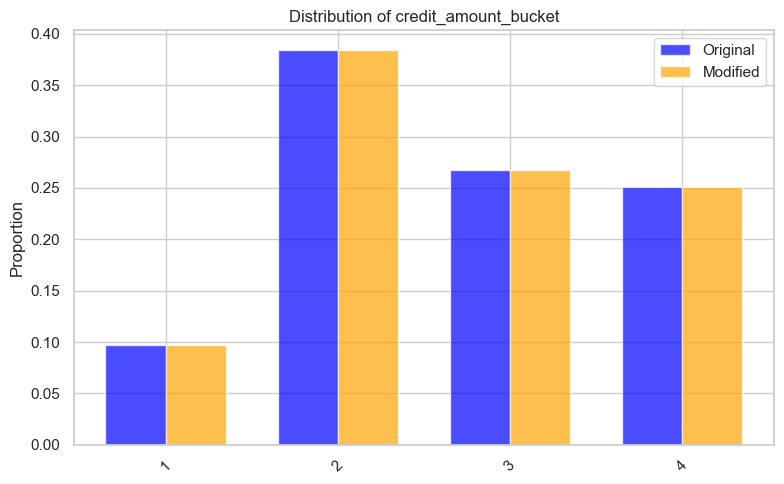

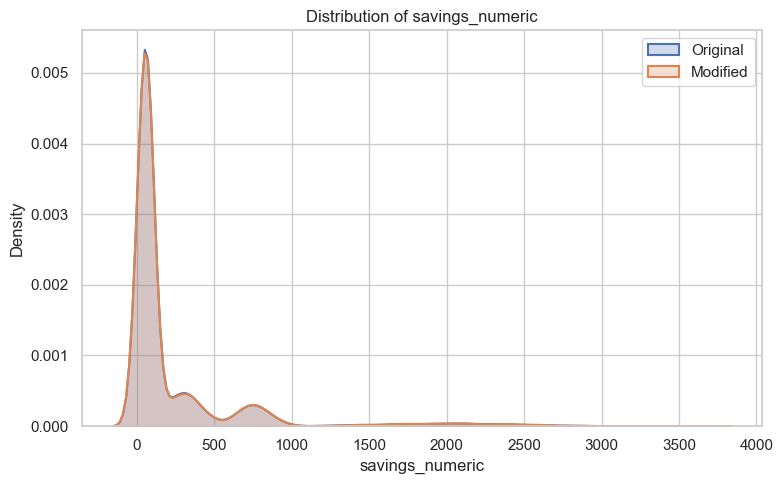

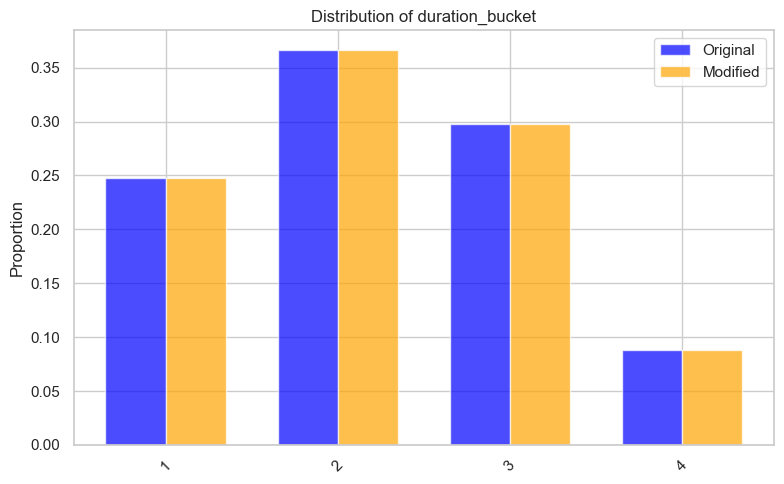

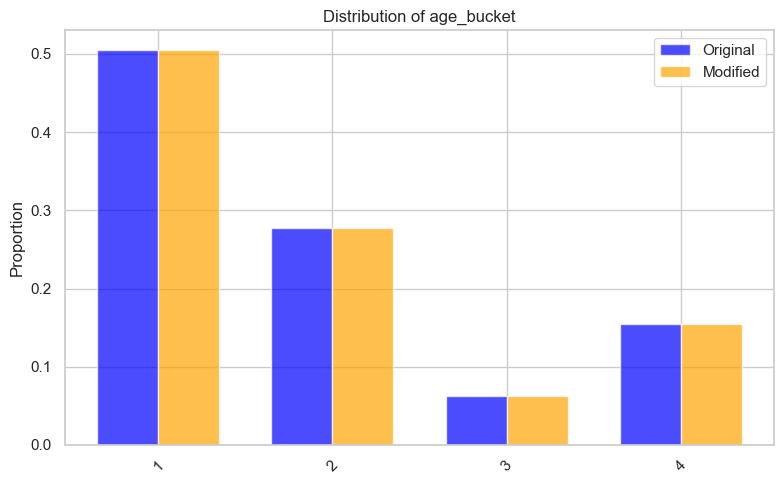


== Mean & Standard Deviation Differences ==
sex                           : mean diff = 0.0022, std diff = 0.0015
marital_status                : mean diff = 0.0001, std diff = 0.0007
job                           : mean diff = 0.0048, std diff = 0.0054
credit_hist                   : mean diff = 0.0047, std diff = 0.0021
purpose                       : mean diff = 0.0520, std diff = 0.0504
installment_rate              : mean diff = 0.0045, std diff = 0.0002
debtors                       : mean diff = 0.0001, std diff = 0.0002
residence_since               : mean diff = 0.0000, std diff = 0.0000
property                      : mean diff = 0.0013, std diff = 0.0024
installment_other             : mean diff = 0.0000, std diff = 0.0000
housing                       : mean diff = 0.0004, std diff = 0.0010
existing_credits              : mean diff = 0.0000, std diff = 0.0000
liable_people                 : mean diff = 0.0000, std diff = 0.0000
tel                           : mean diff = 0

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import pairwise_distances
import numpy as np

# === Distribution plots (better formatting) ===
columns_to_plot = ['credit_amount_bucket', 'savings_numeric', 'duration_bucket', 'age_bucket']

for col in columns_to_plot:
    plt.figure(figsize=(8, 5))
    
    if df_original[col].dtype == 'object' or 'bucket' in col.lower():
        orig_counts = df_original[col].value_counts(normalize=True).sort_index()
        mod_counts = df_modified[col].value_counts(normalize=True).reindex(orig_counts.index).fillna(0)

        x = np.arange(len(orig_counts))
        width = 0.35
        plt.bar(x - width/2, orig_counts.values, width, label='Original', color='blue', alpha=0.7)
        plt.bar(x + width/2, mod_counts.values, width, label='Modified', color='orange', alpha=0.7)
        plt.xticks(ticks=x, labels=orig_counts.index, rotation=45)
        plt.ylabel('Proportion')
        plt.title(f'Distribution of {col}')
    else:
        sns.kdeplot(df_original[col], label='Original', fill=True, linewidth=1.5)
        sns.kdeplot(df_modified[col], label='Modified', fill=True, linewidth=1.5)
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.title(f'Distribution of {col}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n== Mean & Standard Deviation Differences ==")
numeric_cols = df_original.select_dtypes(include='number').columns.drop("default")

for col in numeric_cols:
    mean_diff = abs(df_original[col].mean() - df_modified[col].mean())
    std_diff = abs(df_original[col].std() - df_modified[col].std())
    print(f"{col:<30}: mean diff = {mean_diff:.4f}, std diff = {std_diff:.4f}")


print("\n== Largest Correlation Changes ==")
orig_corr = df_original[numeric_cols].corr()
mod_corr = df_modified[numeric_cols].corr()
corr_diff = (orig_corr - mod_corr).abs()

corr_diff_unstacked = corr_diff.where(np.triu(np.ones(corr_diff.shape), k=1).astype(bool))
largest_diffs = corr_diff_unstacked.stack().sort_values(ascending=False).head(10)
print(largest_diffs)

def kl_divergence(col):
    p = df_original[col].value_counts(normalize=True).sort_index()
    q = df_modified[col].value_counts(normalize=True).reindex(p.index).fillna(0)
    return entropy(p, q)

bucketed_features = ['age_bucket', 'checking_account_numeric', 'savings_numeric', 'duration_bucket']

print("\n== Average Pairwise Distance ==")
sample_cols = numeric_cols[:10]

orig_sample = df_original[sample_cols].sample(500, random_state=42)
mod_sample = df_modified[sample_cols].sample(500, random_state=42)

orig_dist = pairwise_distances(orig_sample, metric='euclidean')
mod_dist = pairwise_distances(mod_sample, metric='euclidean')

print(f"Original avg pairwise distance: {orig_dist.mean():.4f}")
print(f"Modified avg pairwise distance: {mod_dist.mean():.4f}")